In [1]:
# Importing libraries
import numpy as np
import matplotlib
import pandas as pd
from matplotlib import cm
from matplotlib import pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
import math
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from math import log, exp, sqrt
from scipy.stats import norm
%matplotlib inline

### Black-Scholes Equation

In [2]:
def d1(t, S, K, T, r, sigma):
    # Avoid division by zero and handle invalid values
    if sigma == 0 or T == t or K == 0:
        return 0
    return (np.log(S/K) + (r + 0.5 * sigma**2) * (T-t)) / (sigma * np.sqrt(T-t))

In [3]:
def d2(t,S,K,T,r,sigma):
    return d1(t,S,K,T,r,sigma) - sigma * np.sqrt(T-t)

In [4]:
def Call_BS(t,S,K,T,r,sigma):
    if t == T:
        return max(S-K,0)
    else:
        return S * norm.cdf(d1(t,S,K,T,r,sigma)) - K * np.exp(-r*(T-t)) * norm.cdf(d2(t,S,K,T,r,sigma))

In [5]:
def Put_BS(t,S,K,T,r,sigma):
    if t == T:
        return max(K-S,0)
    else:
        return K * np.exp(-r*(T-t)) * norm.cdf(-d2(t,S,K,T,r,sigma)) - S * norm.cdf(-d1(t,S,K,T,r,sigma))

In [6]:
def Vega_BS(t,S,K,T,r,sigma):
    if t == T:
        return 0   # Vega is expired at maturity
    return S * np.sqrt(T-t) * norm.pdf(d1(t,S,K,T,r,sigma)**2)

In [7]:
def test_Call_Vega(N):
    call_test = []
    vega_test = []
    S_test = []
    for i in range(N):
        S_test.append(0.2*i)
        call_test.append(Call_BS(0,S_test[i],10,1,0.1,0.5))
        vega_test.append(Vega_BS(0, S_test[i],10,1,0.1,0.5))
    plt.plot(S_test, call_test)
    plt.title('Test Call BS')
    plt.show()
    plt.plot(S_test, vega_test)
    plt.title('Test Vega BS')
    plt.show()
    

/var/folders/17/qc27rbtn21z7zzm339g7gth80000gn/T/ipykernel_39423/1136859792.py:5: RuntimeWarning: divide by zero encountered in log
  return (np.log(S/K) + (r + 0.5 * sigma**2) * (T-t)) / (sigma * np.sqrt(T-t))


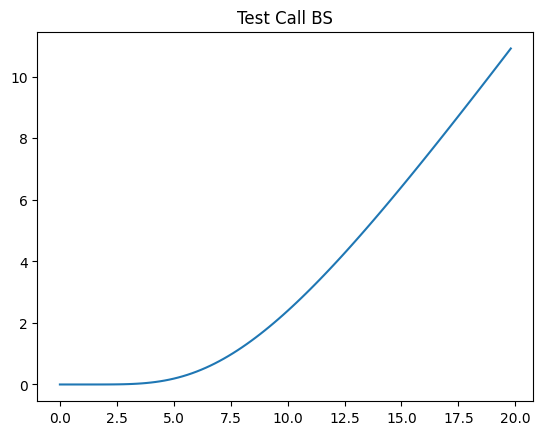

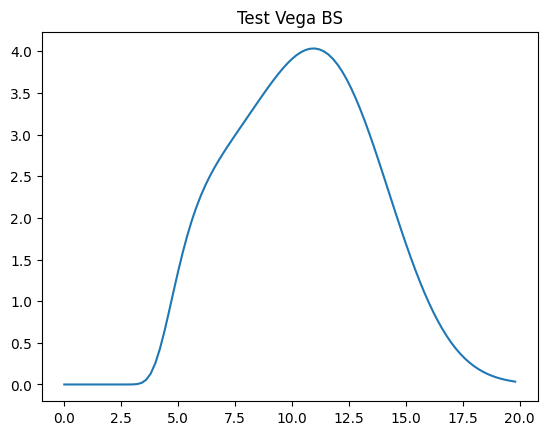

In [8]:
test_Call_Vega(100)

## Implied Volatility Calibration with LIFFE Option prices (2001)

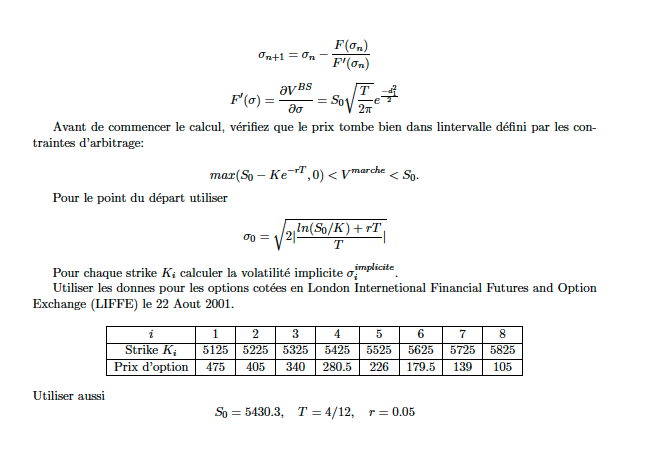

In [9]:
def F_Call(Market,t,S,K,T,r,sigma): 
    return Call_BS(t,S,K,T,r,sigma) - Market

In [10]:
def F_Put(Market,t,S,K,T,r,sigma):
    return Put_BS(t,S,K,T,r,sigma) - Market

In [11]:
def impliedVolatilityCall():
    t = 0
    r = 0.05
    T = 1/3 # 4/12
    S0 = 5430.3
    epsilon = 1e-4

    K = [5125,5225,5325,5425,5525,5625,5725,5825] # Strike
    M = [475,405,340,280.5,226,179.5,138,105]  # Option price
    implied_volatility = []
    for i in range(8):
        if M[i] < S0 and M[i] >= max(S0 - K[i] * np.exp(-r * T),0): # arbitrary condition
            sigma = np.sqrt(2 * np.abs(np.log(S0/K[i]) + r * T) / T)
            while np.abs(F_Call(M[i],t,S0,K[i],T,r,sigma)) > epsilon:
                sigma = sigma - F_Call(M[i],t,S0,K[i],T,r,sigma) / Vega_BS(t,S0,K[i],T,r,sigma)
            implied_volatility.append(sigma) # sigma s.t Black-Scholes analytical price formula = Observed market price
    print(implied_volatility)
    plt.plot(K, implied_volatility)
    plt.xlabel('Strike')
    plt.ylabel('Volatility')
    plt.show
    

[np.float64(0.19017750522959037), np.float64(0.18943147669880386), np.float64(0.1877921461458264), np.float64(0.18552478870358294), np.float64(0.18206544879177197), np.float64(0.17968655212375442), np.float64(0.1759172135010286), np.float64(0.1737863711054463)]


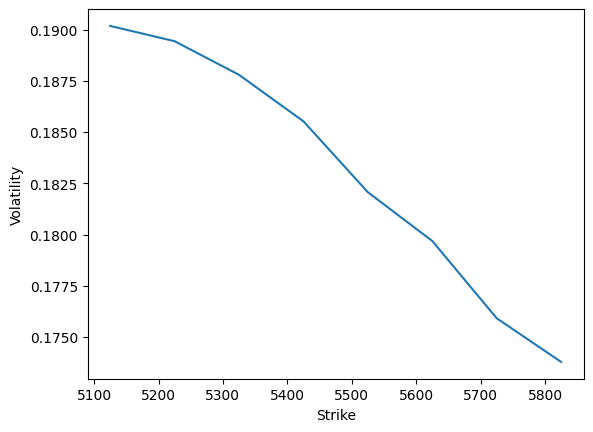

In [12]:
impliedVolatilityCall()

In [13]:
def impliedVolatilityPut():
    t = 0
    r = 0.05
    T = 1 / 3 # 4/12
    S0 = 5430.3
    epsilon = 1e-4
    K = [5125,5225,5325,5425,5525,5625,5725,5825] # Strike
    M = [475,405,340,280.5,226,179.5,138,105]  # Option price
    implied_volatility = []
    for i in range(8):
        if M[i] < K[i] * np.exp(-r * T) and M[i] >= max(S0 - K[i] * np.exp(-r * T), 0) - S0 + K[i] * np.exp(-r * T): # Put arbitrary condition
            sigma = np.sqrt(2 * np.abs(np.log(S0 / K[i]) + r * T) / T)
            while np.abs(F_Put(M[i],t,S0,K[i],T,r,sigma)) > epsilon:
                sigma = sigma - F_Put(M[i],t,S0,K[i],T,r,sigma) / Vega_BS(t,S0,K[i],T,r,sigma)
        implied_volatility.append(sigma)
    print(implied_volatility)
    plt.plot(K, implied_volatility)
    plt.xlabel('Strike')
    plt.ylabel('Volatility')
    plt.show()


[np.float64(0.5427597956520619), np.float64(0.4435808597722637), np.float64(0.35045832235558555), np.float64(0.26302563393742695), np.float64(0.17936038039905322), np.float64(0.09660757851977315), np.float64(0.09660757851977315), np.float64(0.09660757851977315)]


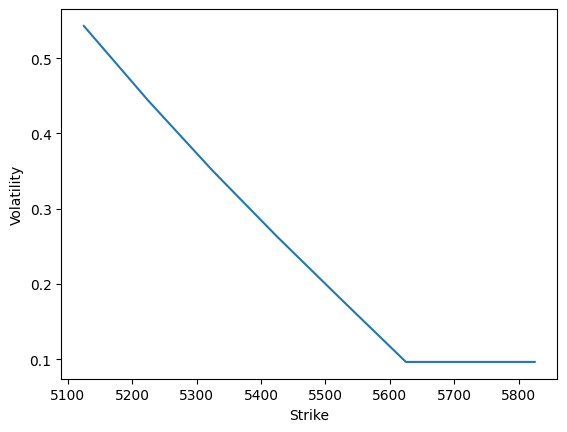

In [14]:
impliedVolatilityPut()

## Implied Volatility Calibration with Put options on SP500 index


In [15]:
df = pd.read_csv('sp-index.txt', sep="\t")
print(df)

            T  Unnamed: 1      K     Cb     Ca      Pb    Pa   r
0    0.083333         800  459.6  461.6    0.0    0.25  4.60 NaN
1    0.083333         850  409.8  411.8    0.0    0.25  4.60 NaN
2    0.083333         900  360.0  362.0    0.0    0.50  4.60 NaN
3    0.083333         950  310.3  312.3    0.1    0.20  4.60 NaN
4    0.083333        1000  260.5  262.5    0.1    0.50  4.60 NaN
..        ...         ...    ...    ...    ...     ...   ...  ..
275  2.916667        1500   69.8   73.8  192.3  196.30  4.78 NaN
276  2.916667        1600   41.2   45.2  250.7  254.70  4.78 NaN
277  2.916667        1700   22.5   25.5  318.5  322.50  4.78 NaN
278  2.916667        1800   11.2   13.7  393.8  397.80  4.78 NaN
279  2.916667        1900    5.4    6.9  474.5  478.50  4.78 NaN

[280 rows x 8 columns]


In [16]:
corrected_df = pd.DataFrame({
    'T': df['T'].reset_index(drop=True),
    'K': df.iloc[:, 1].astype(float).reset_index(drop=True),
    'Cb': df.iloc[:, 2].reset_index(drop=True),
    'Ca': df.iloc[:, 3].reset_index(drop=True),
    'Pb': df.iloc[:, 4].reset_index(drop=True),
    'Pa': df.iloc[:, 5].reset_index(drop=True),
    'r': df.iloc[:, 6].reset_index(drop=True)
})
print(corrected_df)
#for element in corrected_df.columns:
#   print(len(df[element]))

            T       K     Cb     Ca     Pb      Pa     r
0    0.083333   800.0  459.6  461.6    0.0    0.25  4.60
1    0.083333   850.0  409.8  411.8    0.0    0.25  4.60
2    0.083333   900.0  360.0  362.0    0.0    0.50  4.60
3    0.083333   950.0  310.3  312.3    0.1    0.20  4.60
4    0.083333  1000.0  260.5  262.5    0.1    0.50  4.60
..        ...     ...    ...    ...    ...     ...   ...
275  2.916667  1500.0   69.8   73.8  192.3  196.30  4.78
276  2.916667  1600.0   41.2   45.2  250.7  254.70  4.78
277  2.916667  1700.0   22.5   25.5  318.5  322.50  4.78
278  2.916667  1800.0   11.2   13.7  393.8  397.80  4.78
279  2.916667  1900.0    5.4    6.9  474.5  478.50  4.78

[280 rows x 7 columns]


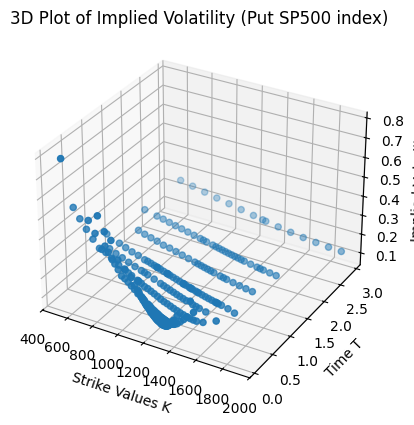

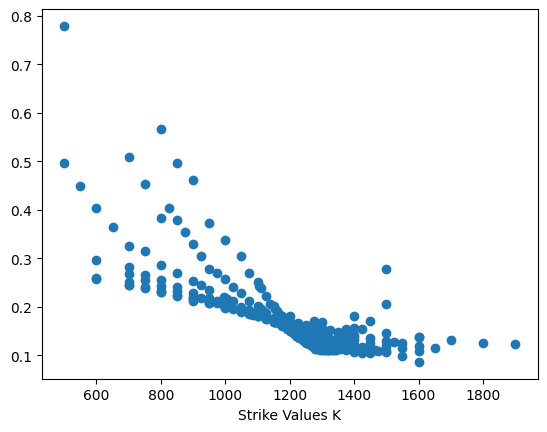

In [17]:
import numpy as np
from scipy.stats import norm

# Define the Black-Scholes functions
def d1(t, S, K, T, r, sigma):
    # Avoid division by zero and handle invalid values
    if sigma == 0 or T == t:
        return 0
    return (np.log(S/K) + (r + 0.5 * sigma**2) * (T-t)) / (sigma * np.sqrt(T-t))

def d2(t, S, K, T, r, sigma):
    return d1(t, S, K, T, r, sigma) - sigma * np.sqrt(T-t)

def Put_BS(t, S, K, T, r, sigma):
    if T == t:  # Option has expired
        return max(K - S, 0)
    else:
        return K * np.exp(-r*(T-t)) * norm.cdf(-d2(t, S, K, T, r, sigma)) - S * norm.cdf(-d1(t, S, K, T, r, sigma))

def Vega_BS(t, S, K, T, r, sigma):
    if T == t:  # Vega is zero at expiration
        return 0
    d1_val = d1(t, S, K, T, r, sigma)
    return S * np.sqrt(T - t) * norm.pdf(d1_val)
    
# Newton-Raphson method to find implied volatility
def implied_volatility(Market, t, S, K, T, r, sigma_initial, epsilon=1e-5, max_iter=100):
    sigma = sigma_initial
    for _ in range(max_iter):
        F_value = F_Put(Market, t, S, K, T, r, sigma)
        Vega = Vega_BS(t, S, K, T, r, sigma)
        
        if Vega == 0:  # Avoid division by zero
            break
        
        sigma_new = sigma - F_value / Vega
        
        if np.abs(sigma_new - sigma) < epsilon:  # Convergence criterion
            return sigma_new
        
        sigma = sigma_new
    
    return sigma  # Return the last sigma found after max iterations

# Step 1: Initialize necessary lists
T = []
K = []
r = []
M = []
S = []
vol_implicite = []

q=0.0217
epsilon=0.0001
t=0
S0=1260.36

# Assuming N is the length of the dataset (number of rows in df)
N = len(corrected_df)

# Step 2: Loop through the dataset and populate T, K, Ca, Cb, M, r, S lists
for i in range(N):
    T.append(corrected_df.iloc[i, 0])  
    K.append(corrected_df.iloc[i, 1])
    Pa = corrected_df.iloc[i, 5]  
    Pb = corrected_df.iloc[i, 4]  
    M.append((Pa + Pb) / 2)  # Calculate average of Ca and Cb
    r.append(corrected_df.iloc[i, 6] * 0.01)  # Convert interest rate to percentage (assuming r in 7th column)
    S.append(S0 * np.exp(-q * T[i]))  # Calculate S using given formula

# Modified loop for calculating implied volatility
for i in range(N):
    if M[i] < K[i] * np.exp(-r[i] * T[i]) and M[i] >= max(S[i] - K[i] * np.exp(-r[i] * T[i]), 0) - S[i] + K[i] * np.exp(-r[i] * T[i]):
        # Initial guess for volatility
        sigma_initial = np.sqrt(2 * np.abs(np.log(r[i] * T[i] + S[i] / K[i])) / T[i])
        
        # Use the Newton-Raphson method to refine sigma
        sigma = implied_volatility(M[i], t, S[i], K[i], T[i], r[i], sigma_initial)
        
        vol_implicite.append(sigma)  # Append the calculated implied volatility
    else:
        vol_implicite.append(0)  # Append 0 if conditions are not met


# Step 4: Clean up vol_implicite, K, and T lists based on zero volatility values
array_test = np.array(vol_implicite)
indices = np.where(array_test == 0)[0]

# Remove indices from vol_implicite, K, T lists
x = 0
for i in indices:
    vol_implicite.pop(i - x)
    K.pop(i - x)
    T.pop(i - x)
    x += 1

# Step 5: Graphical display of implied volatility vs K and T
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot implied volatility
ax.scatter(K, T, vol_implicite)

# Label the axes
ax.set_xlabel("Strike Values K")
ax.set_ylabel("Time T")
ax.set_zlabel("Implied Volatility")

plt.title("3D Plot of Implied Volatility (Put SP500 index)")
plt.show()

plt.scatter(K, vol_implicite)
plt.xlabel('Strike Values K')
plt.show()

## Implied Volatility Calibration with Call options on SP500 index

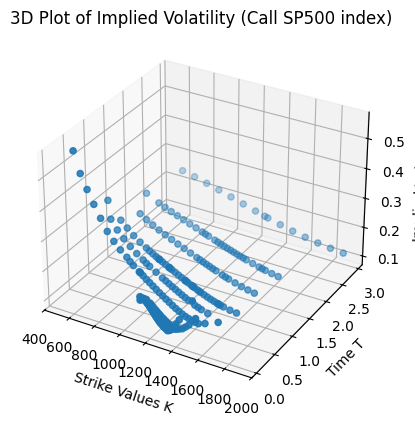

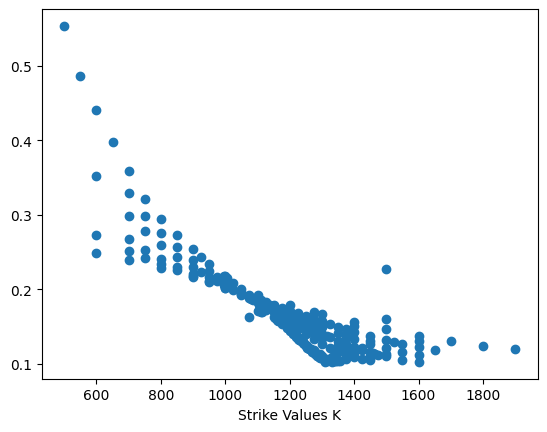

In [18]:
import numpy as np
from scipy.stats import norm

# Define the Black-Scholes functions
def d1(t, S, K, T, r, sigma):
    # Avoid division by zero and handle invalid values
    if sigma == 0 or T == t:
        return 0
    return (np.log(S/K) + (r + 0.5 * sigma**2) * (T-t)) / (sigma * np.sqrt(T-t))

def d2(t, S, K, T, r, sigma):
    return d1(t, S, K, T, r, sigma) - sigma * np.sqrt(T-t)

def Put_BS(t, S, K, T, r, sigma):
    if T == t:  # Option has expired
        return max(K - S, 0)
    else:
        return K * np.exp(-r*(T-t)) * norm.cdf(-d2(t, S, K, T, r, sigma)) - S * norm.cdf(-d1(t, S, K, T, r, sigma))

def Vega_BS(t, S, K, T, r, sigma):
    if T == t:  # Vega is zero at expiration
        return 0
    d1_val = d1(t, S, K, T, r, sigma)
    return S * np.sqrt(T - t) * norm.pdf(d1_val)

# Newton-Raphson method to find implied volatility
def implied_volatility(Market, t, S, K, T, r, sigma_initial, epsilon=1e-5, max_iter=100):
    sigma = sigma_initial
    for _ in range(max_iter):
        F_value = F_Call(Market, t, S, K, T, r, sigma)
        Vega = Vega_BS(t, S, K, T, r, sigma)
        
        if Vega == 0:  # Avoid division by zero
            break
        
        sigma_new = sigma - F_value / Vega
        
        if np.abs(sigma_new - sigma) < epsilon:  # Convergence criterion
            return sigma_new
        
        sigma = sigma_new
    
    return sigma  # Return the last sigma found after max iterations

    
# Step 1: Initialize necessary lists
T = []
K = []
r = []
M = []
S = []
vol_implicite = []

q=0.0217
# epsilon=0.0001
t=0
S0=1260.36

# Assuming N is the length of the dataset (number of rows in df)
N = len(corrected_df)

# Step 2: Loop through the dataset and populate T, K, Ca, Cb, M, r, S lists
for i in range(N):
    T.append(corrected_df.iloc[i, 0])  
    K.append(corrected_df.iloc[i, 1])
    Ca = corrected_df.iloc[i, 3]  
    Cb = corrected_df.iloc[i, 2]  
    M.append((Ca + Cb) / 2)  # Calculate average of Ca and Cb
    r.append(corrected_df.iloc[i, 6] * 0.01)  # Convert interest rate to percentage (assuming r in 7th column)
    S.append(S0 * np.exp(-q * T[i]))  # Calculate S using given formula

# Modified loop for calculating implied volatility
for i in range(N):
    if M[i] < S[i] and M[i] >= max(S[i] - K[i] * np.exp(-r[i] * T[i]),0):
        # Initial guess for volatility
        sigma_initial = np.sqrt(2 * np.abs(np.log(S[i] / K[i]) + r[i] * T[i]) / T[i])
        
        # Use the Newton-Raphson method to refine sigma
        sigma = implied_volatility(M[i], t, S[i], K[i], T[i], r[i], sigma_initial)
        
        vol_implicite.append(sigma)  # Append the calculated implied volatility
    else:
        vol_implicite.append(0)  # Append 0 if conditions are not met


# Step 4: Clean up vol_implicite, K, and T lists based on zero volatility values
array_test = np.array(vol_implicite)
indices = np.where(array_test == 0)[0]

# Remove indices from vol_implicite, K, T lists
x = 0
for i in indices:
    vol_implicite.pop(i - x)
    K.pop(i - x)
    T.pop(i - x)
    x += 1

# Step 5: Graphical display of implied volatility vs K and T
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot implied volatility
ax.scatter(K, T, vol_implicite)

# Label the axes
ax.set_xlabel("Strike Values K")
ax.set_ylabel("Time T")
ax.set_zlabel("Implied Volatility")

plt.title("3D Plot of Implied Volatility (Call SP500 index)")
plt.show()

plt.scatter(K, vol_implicite)
plt.xlabel('Strike Values K')
plt.show()